In [62]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp -r gdrive/My\ Drive/tools/ .
!cp -r gdrive/My\ Drive/models/ .
!cp -r gdrive/My\ Drive/x96_extrapolation/ .
!ls -l

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 20
drwx------ 3 root root 4096 May  1 07:14 gdrive
drwx------ 3 root root 4096 May  1 10:20 models
drwxr-xr-x 1 root root 4096 Apr  4 20:20 sample_data
drwx------ 3 root root 4096 May  1 07:14 tools
drwx------ 2 root root 4096 May  1 10:21 x96_extrapolation


In [1]:
import numpy as np
import torch
import torch.nn as nn

import models.autoencoder as AE
import tools._my_tools as mt
import tools._torch_tools as tt

import tools.AR_data as ar

device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)

data_f = "x96_extrapolation/"
X_train, y_train = mt.loadData(data_f,train=True,typeF='float16')

Device is cuda:0
Loading x96_extrapolation/X_train.npy
Loading x96_extrapolation/y_train.npy


In [4]:
X_val, y_val = mt.loadData(data_f,val=True,typeF='float16')

Loading x96_extrapolation/X_val.npy
Loading x96_extrapolation/y_val.npy


In [0]:
ae = AE.Model("models/data/autoencoder.pth",device=device).to(device).eval()

In [0]:
class Model(nn.Module):
    def __init__(self, batch_size):
        super(Model, self).__init__()
        
        self.batch_size = batch_size
        self.lstm = nn.LSTM(576,288,num_layers=2,dropout=0.05)
        self.linear = nn.Linear(288,576)
    
    def predict(self, x):   
        out, hid = self.lstm(x)
        res = self.linear(out[-1:].view(1,-1)).view(1,1,-1)
        
        for i in range(x.shape[0] - 1):
            out, hid = self.lstm(res[-1:], hid)
            res = torch.cat((res,self.linear(out[-1:].view(1,-1)).view(1,1,-1)),0)
        
        return res
    
    def forward(self, x):
        x = x.view(3,self.batch_size,-1)
        
        out, hid = self.lstm(x)
        res = self.linear(out[-1:].view(self.batch_size,-1))
        
        return res.view(1,self.batch_size,-1)

class Training(tt.Training):
    def __init__(self,*args,**kwargs):
        super(Training,self).__init__(*args,**kwargs)
        self.ae = AE.Model("models/data/autoencoder.pth",device=device).to(device).eval()
        
    def getBatch(self, offset, batch_size, val=False):
        if val is True:
            X = self.X_val
            y = self.y_val
        else:
            X = self.X
            y = self.y

        input = torch.autograd.Variable(
            torch.tensor( X[ offset:offset + batch_size ], dtype=torch.float )
        ).to(self.device)
        input = self.ae.encode(input.view(input.shape[1]*batch_size,1,input.shape[2],input.shape[3]))
#         print(input.shape)

        target = torch.autograd.Variable(
            torch.tensor( y[ offset:offset + batch_size ], dtype=torch.float )
        ).to(self.device)
        target = self.ae.encode(target.view(target.shape[1]*batch_size,1,target.shape[2],target.shape[3]))
#         print(target.shape)

        return input.view(3,batch_size,-1), target.view(3,batch_size,-1)[0:1]

In [94]:
test = Model().to(device)
a = torch.tensor(X_val[0:1,:,:,:],dtype=torch.float).to(device)
tar = torch.tensor(y_val[0:1,:,:,:],dtype=torch.float).to(device)
b = ae.encode(a.view(3,1,96,96))
print(b.shape)
b = b.view(3,1,-1)
print(b.shape)
out = test(b)
print(out.shape)

torch.Size([3, 16, 6, 6])
torch.Size([3, 1, 576])
torch.Size([1, 1, 576])


In [0]:
model = Model(8)
training = Training(model, device, X_train, y_train, X_val, y_val, loss_function=nn.MSELoss())
# a = training.getBatch(0,1)
# print(a[0].shape)
# print(a[1].shape)

In [23]:
try:
    training.fit(8,1,val=True)
except KeyboardInterrupt:
    print("\n------------\nFinished training.")

====== HYPERPARAMETERS ======
batch_size : 8
epochs : 1
loss function : MSELoss()
optimizer : Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
device : cuda:0
===> Epoch[1](8451/8451): Loss: 0.0524	ETA 0:00:00	Epoch Loss: 0.0382
Epoch[1] finished in 0:03:09 with loss 0.03820848249585766
Validating on 16904 samples.
===> Validating (2113/2113):	ETA 0:00:00	Validation Loss: 0.0382
Validation loss = 0.0382

----------------------------

Finished training of 1 epochs in 0:03:28.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(96, 288)
(96, 192)


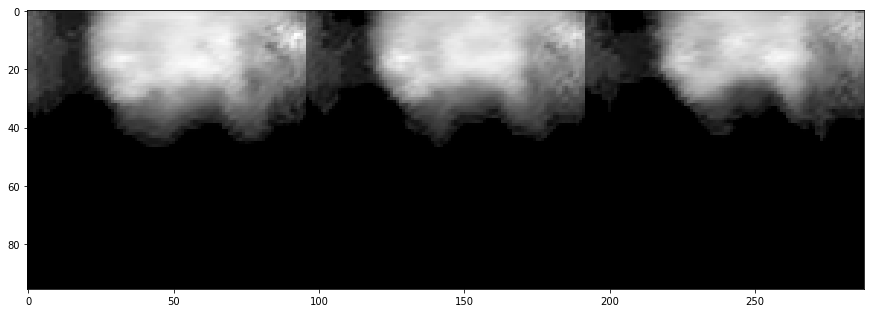

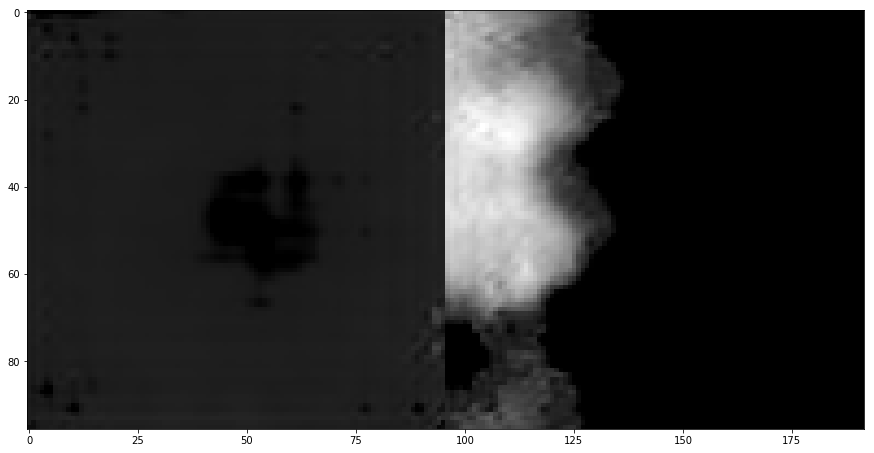

In [26]:
a,b = training.getBatch(10,1)
out = model.predict(a)
# print(out[0,0])
out = out.view(-1,16,6,6)
res = training.ae.decode(out).cpu().detach().numpy()
tar = b.view(-1,16,6,6)
tar = training.ae.decode(tar).cpu().detach().numpy()
# print(res.shape)
i = 0
tmp = training.ae.decode(a.view(-1,16,6,6)).cpu().detach().numpy()
# print(tmp.shape)
mt.showImgGC("",tmp[0,0,:,:].astype('float32'),tmp[1,0,:,:].astype('float32'),tmp[2,0,:,:].astype('float32'),size=(15,15))
mt.showImgGC("",res[i,0,:,:].astype('float32'),tar[0,0,:,:].astype('float32'),size=(15,15))

(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)


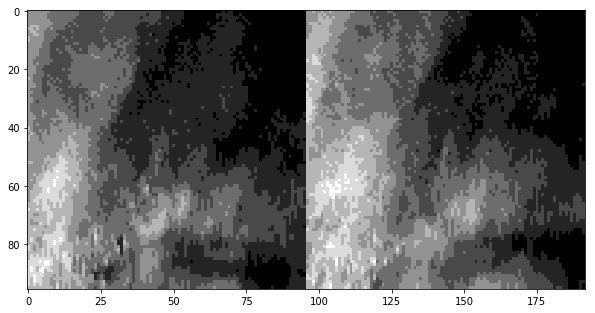

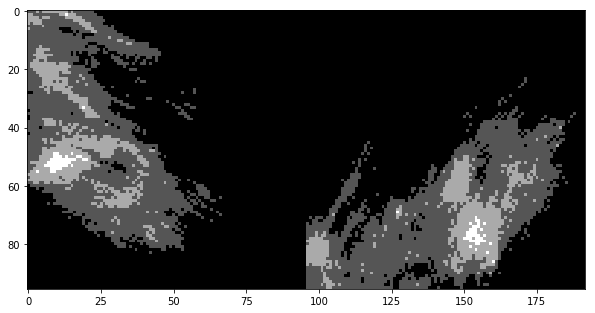

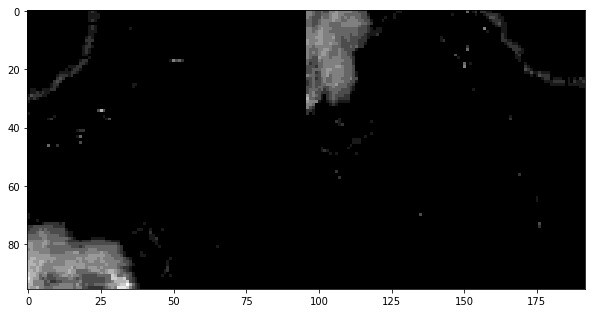

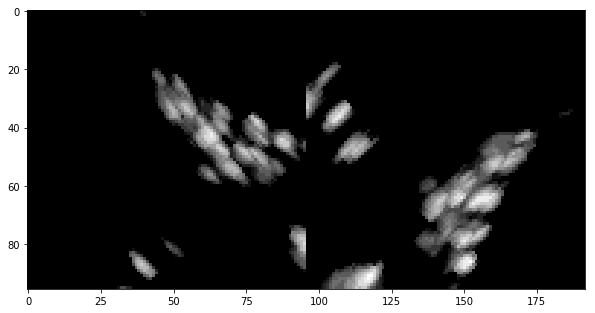

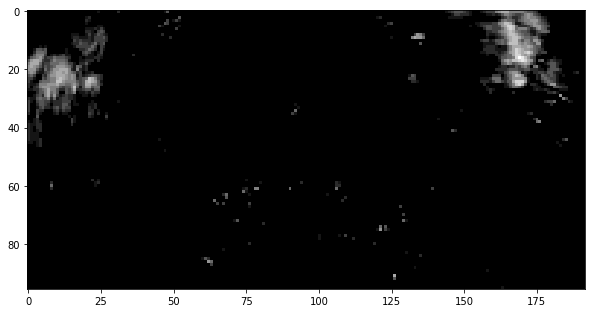

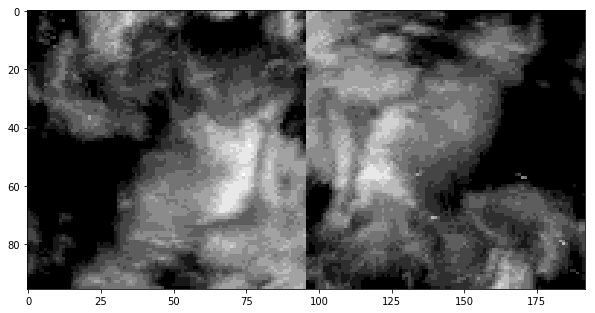

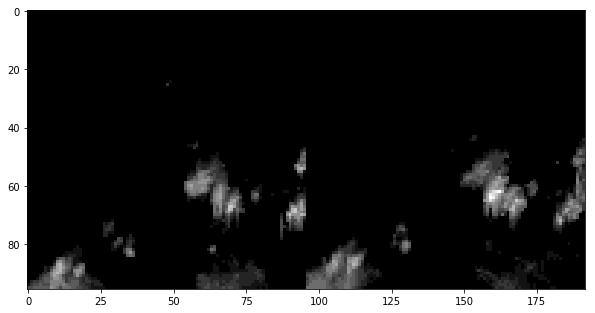

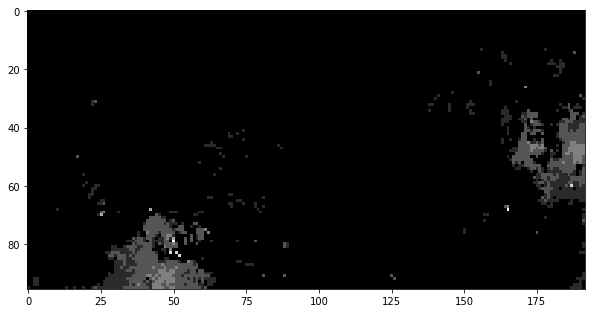

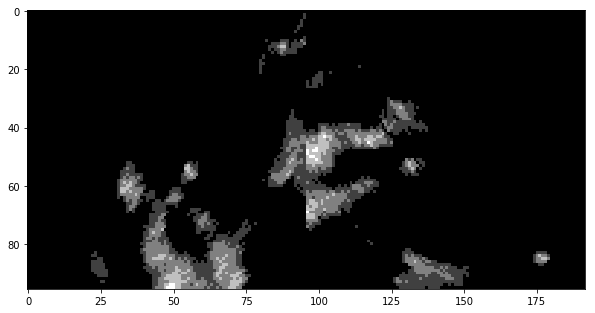

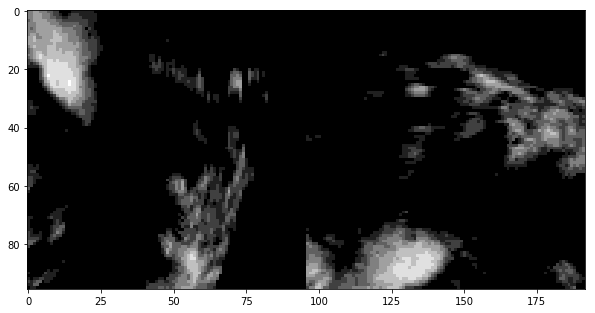

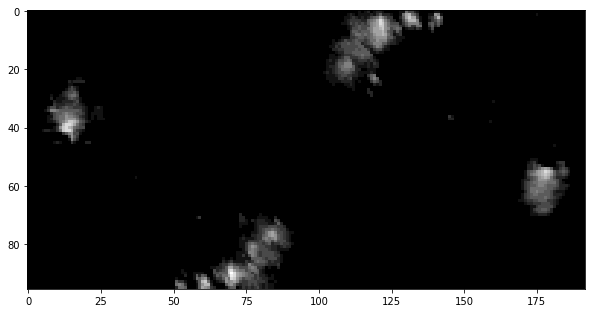

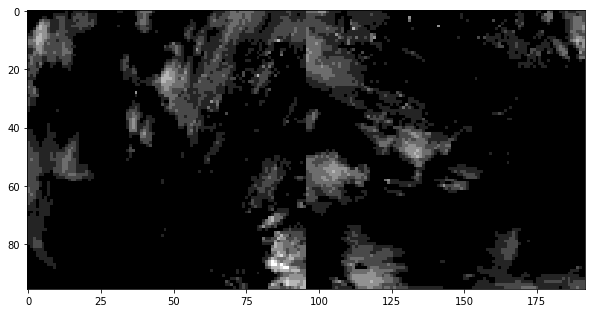

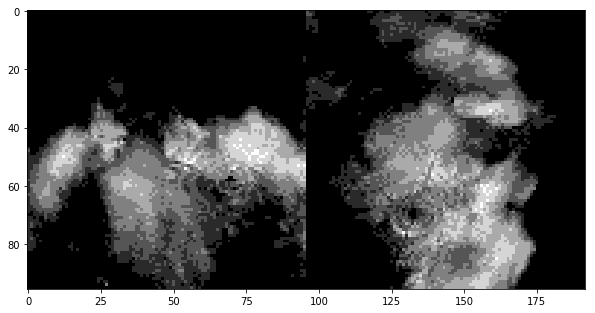

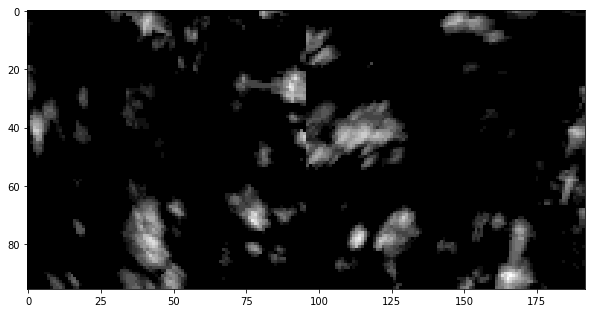

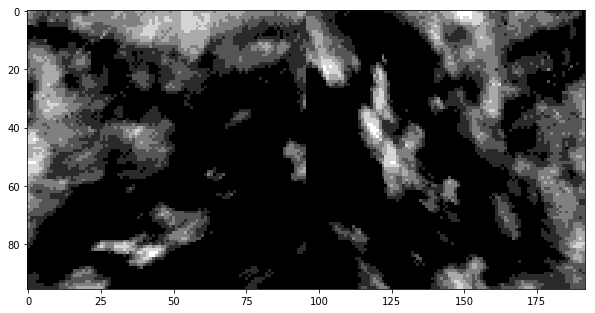

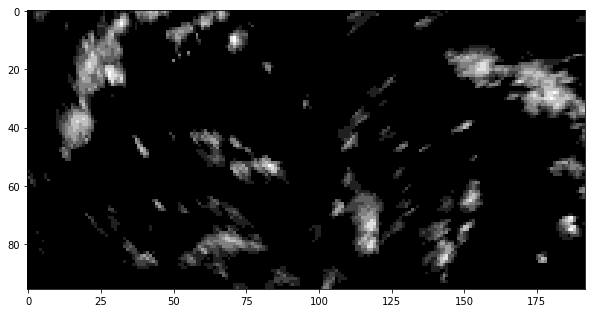

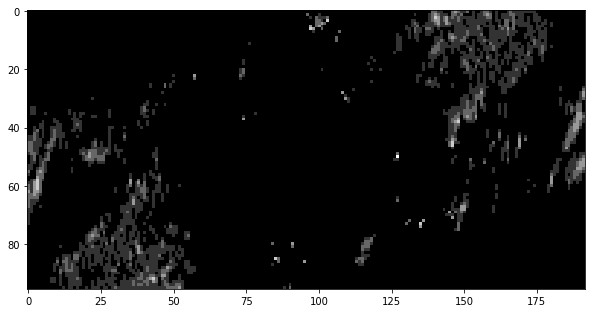

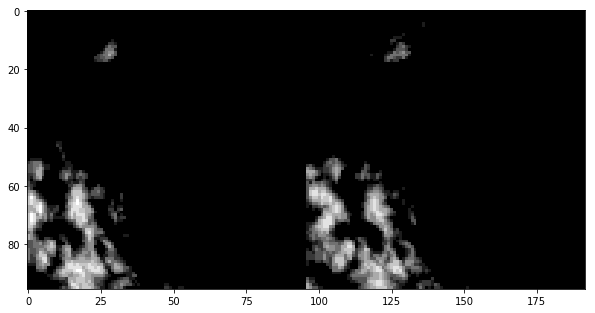

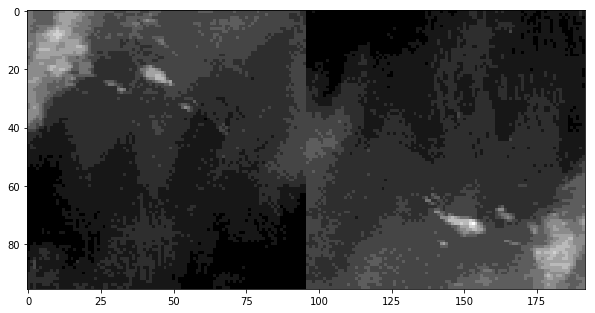

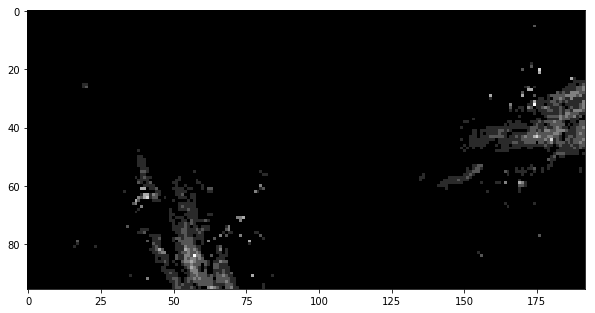

In [30]:
for i in range(20):
    mt.showImgGC("",X_val[i,2,:,:].astype('float32'),y_val[i,0,:,:].astype('float32'),size=(10,10))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(96, 192)


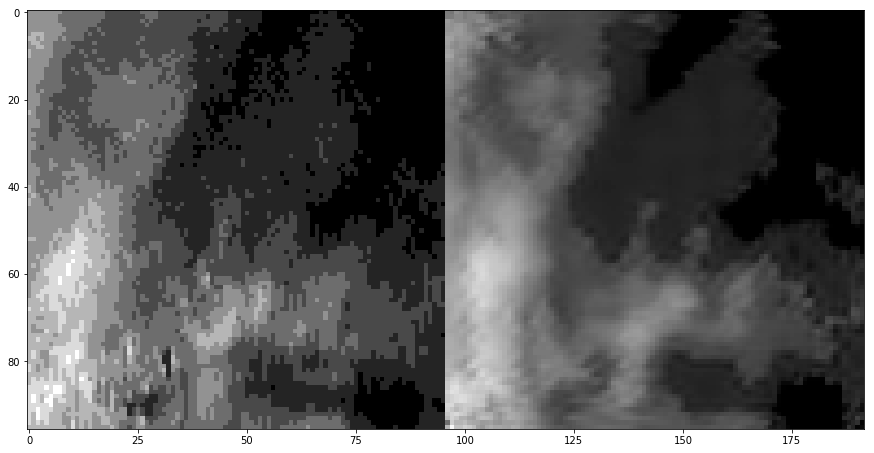

In [85]:
a = X_train[0:1,2:,:,:]
b = ae.encode(torch.tensor(a,dtype=torch.float).to(device)).view(-1).view(-1,16,6,6)
c = ae.decode(b).cpu().detach().numpy()
mt.showImgGC("",a.squeeze().astype('float32'),c.squeeze().astype('float32'),size=(15,15))

In [84]:
b.view(-1).view(-1,16,6,6).shape


torch.Size([1, 16, 6, 6])

In [0]:
data = ar.ARData(num_datapoints=500, num_prev=3, num_aft=3)

In [40]:
data.y_train.shape

(398, 3)

In [41]:
data.X_train.shape

(398, 3)

In [42]:
print(data.X_train[0:3])
print("---------")
data.y_train[0:3]

[[ 1.44611489  0.12825277  0.71865155]
 [ 0.12825277  0.71865155 -0.19387912]
 [ 0.71865155 -0.19387912 -0.98123235]]
---------


array([[-0.19387912, -0.98123235, -1.68245749],
       [-0.98123235, -1.68245749,  0.52490186],
       [-1.68245749,  0.52490186,  0.07494372]])

In [0]:
# data.x.shape
data.y_train.shape

(40, 1)

In [126]:
n_epochs = 100
batch_size = 1

class Model_A(nn.Module):
    def __init__(self):
        super(Model_A, self).__init__()
        
        self.lstm = nn.LSTM(1,4,num_layers=2,dropout=0.05)
        self.linear = nn.Linear(4,1)
    
    def predict(self, x):
        res = []
        out, hid = self.lstm(x)
        res.append(self.linear(out[-1:].view(1,-1)).view(-1,1,1))
                
        for i in range(x.shape[0] - 1):
            out, hid = self.lstm(res[-1], hid)
            res.append(self.linear(out[-1:].view(1,-1)).view(-1,1,1))
            
        res = torch.reshape(torch.tensor(res), (x.shape[0],1,1))
        return res
    
    def forward(self, x):
        out, hid = self.lstm(x)
        res = self.linear(out[-1:].view(2,-1))
        
        return res.view(1,2,1)
    
model_A = Model_A().cuda()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_A.parameters())

X = data.X_train
y = data.y_train
print("here")
for ep in range(n_epochs):
    ep_loss = 0
#     print("blah")
    for i in range(len(X)//2):
#     for inp, tar in zip(X,y):
#         print(str(inp)+'\r',end='',flush=True)
        inp = torch.autograd.Variable(
            torch.tensor( X[i:i+2], dtype=torch.float )
        ).cuda()
        tar = torch.autograd.Variable(
            torch.tensor( y[i:i+2], dtype=torch.float )
        ).cuda()
        inp = torch.reshape(inp,(3,2,1))
        
        tar = torch.reshape(tar[:,0],(1,2,1))
        
        optimizer.zero_grad()
        out = model_A(inp)
        loss = loss_fn(out[-1:],tar)
        ep_loss += loss
        loss.backward()
        optimizer.step()
    print("\r",str(ep),str(ep_loss / len(X)),end='',flush=True)

        

here
 10 tensor(0.6643, device='cuda:0', grad_fn=<DivBackward0>)

KeyboardInterrupt: ignored

In [127]:
model_A.eval()

inp = torch.autograd.Variable(
    torch.tensor( data.X_train[0], dtype=torch.float )
).cuda()
tar = torch.autograd.Variable(
    torch.tensor( data.y_train[0], dtype=torch.float )
).cuda()
inp = torch.reshape(inp,(3,1,1))
tar = torch.reshape(tar,(3,1,1))
print(inp)
print("---------------")
print(model_A.predict(inp))
print("----------------")
print(tar)

val_loss = 0
for inp,tar in zip(data.X_test, data.y_test):
    inp = torch.autograd.Variable(
            torch.tensor( inp, dtype=torch.float )
        ).cuda()
    tar = torch.autograd.Variable(
        torch.tensor( tar, dtype=torch.float )
    ).cuda()
    inp = torch.reshape(inp,(3,1,1))
    tar = torch.reshape(tar,(3,1,1))
    out = model_A.predict(inp)
    loss = loss_fn(out.cuda(),tar)
    val_loss += loss
print("Loss - ", val_loss / len(data.X_test))

tensor([[[1.4461]],

        [[0.1283]],

        [[0.7187]]], device='cuda:0')
---------------
tensor([[[-0.8168]],

        [[-1.0218]],

        [[-1.1339]]])
----------------
tensor([[[-0.1939]],

        [[-0.9812]],

        [[-1.6825]]], device='cuda:0')
Loss -  tensor(2.9228, device='cuda:0')


In [61]:
from torchsummary import summary
print(summary(model_A.cuda(), (3,1,1)))

RuntimeError: ignored

In [45]:
class Model_B(nn.Module):
    def __init__(self):
        super(Model_B, self).__init__()
        
        self.lstm = nn.LSTM(1,4)
        self.linear = nn.Linear(4,1)

    def forward(self, x):
        out, hid = self.lstm(x)
        res = self.linear(out[-1:].view(1,-1)).view(-1,1,1)
        
        for i in range(x.shape[0] - 1):
            out, hid = self.lstm(res[-1:], hid)
            res = torch.cat((res,self.linear(out[-1:].view(1,-1)).view(-1,1,1)),0)
        
        return res
    
model_B = Model_B().cuda()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_B.parameters())

X = data.X_train
y = data.y_train
print("here")
for ep in range(n_epochs):
    ep_loss = 0
#     print("blah")
    for inp, tar in zip(X,y):
#         print(str(inp)+'\r',end='',flush=True)
        inp = torch.autograd.Variable(
            torch.tensor( inp, dtype=torch.float )
        ).cuda()
        tar = torch.autograd.Variable(
            torch.tensor( tar, dtype=torch.float )
        ).cuda()
        inp = torch.reshape(inp,(3,1,1))
        tar = torch.reshape(tar[0],(1,1,1))
        
        optimizer.zero_grad()
        out = model_B(inp)
#         print(out[-1:].shape)
        loss = loss_fn(out[-1:],tar)
        ep_loss += loss
        loss.backward()
        optimizer.step()
    print("\r",str(ep),str(ep_loss / len(X)),end='',flush=True)


here
 99 tensor(1.0982, device='cuda:0', grad_fn=<DivBackward0>)

In [46]:
inp = torch.autograd.Variable(
    torch.tensor( data.X_train[0], dtype=torch.float )
).cuda()
tar = torch.autograd.Variable(
    torch.tensor( data.y_train[0], dtype=torch.float )
).cuda()
inp = torch.reshape(inp,(3,1,1))
tar = torch.reshape(tar,(3,1,1))

print(model_B(inp))
print("----------------")
print(tar)

val_loss = 0
for inp,tar in zip(data.X_test, data.y_test):
    inp = torch.autograd.Variable(
            torch.tensor( inp, dtype=torch.float )
        ).cuda()
    tar = torch.autograd.Variable(
        torch.tensor( tar, dtype=torch.float )
    ).cuda()
    inp = torch.reshape(inp,(3,1,1))
    tar = torch.reshape(tar,(3,1,1))
    out = model_B(inp)
    loss = loss_fn(out,tar)
    val_loss += loss
print("Loss - ", val_loss / len(data.X_test))

tensor([[[ 0.0773]],

        [[-0.2182]],

        [[-0.4582]]], device='cuda:0', grad_fn=<CatBackward>)
----------------
tensor([[[-0.1939]],

        [[-0.9812]],

        [[-1.6825]]], device='cuda:0')
Loss -  tensor(3.1228, device='cuda:0', grad_fn=<DivBackward0>)


===============================================
===============================================
===============================================
===============================================
===============================================
===============================================

In [0]:
# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view((len(input), self.batch_size, -1)))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

lstm_input_size = 1
h1 = 1

model = LSTM(lstm_input_size, h1, batch_size=2)

In [0]:
num_epochs = 10
X_train = data.X_train
y_train = data.y_train
# -----------------------------------------------------
loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters())

#####################
# Train model
#####################

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Clear stored gradient
    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

TypeError: data type not understood

In [0]:
X_train

array([[ 0.4781265 , -0.64181071,  0.93196523],
       [-0.64181071,  0.93196523,  1.24348954],
       [ 0.93196523,  1.24348954, -0.45840917],
       [ 1.24348954, -0.45840917,  0.30812605],
       [-0.45840917,  0.30812605,  0.35834108],
       [ 0.30812605,  0.35834108, -1.38662318],
       [ 0.35834108, -1.38662318,  0.69901411],
       [-1.38662318,  0.69901411,  0.24848427],
       [ 0.69901411,  0.24848427,  0.85752616],
       [ 0.24848427,  0.85752616, -0.11575259],
       [ 0.85752616, -0.11575259,  0.35100975],
       [-0.11575259,  0.35100975,  1.65124456],
       [ 0.35100975,  1.65124456, -1.3922242 ],
       [ 1.65124456, -1.3922242 ,  0.15814128],
       [-1.3922242 ,  0.15814128, -0.08669572],
       [ 0.15814128, -0.08669572, -0.18342843],
       [-0.08669572, -0.18342843, -1.28251734],
       [-0.18342843, -1.28251734,  0.19538482],
       [-1.28251734,  0.19538482,  0.99293658],
       [ 0.19538482,  0.99293658,  1.7376166 ],
       [ 0.99293658,  1.7376166 , -0.402

###########################################################################

In [0]:
hid_base = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))
inp_base = [torch.randn(1, 3) for _ in range(4)]

In [0]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
# inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
inputs = inp_base

# initialize the hidden state.
# hidden = (torch.randn(1, 1, 3),
#           torch.randn(1, 1, 3))
hidden = hid_base

# for i in range(8):
#     # Step through the sequence one element at a time.
#     # after each step, hidden contains the hidden state.
#     out, hidden = lstm(inputs[i].view(1, 1, -1), hidden)
#     inputs.append(out)
#     print(out)
#     print(hidden)
#     print("-------------------")

# print("==============")

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
# hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
hidden = hid_base
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.1053,  0.4817, -0.1503]],

        [[-0.2229,  0.5812, -0.3411]],

        [[ 0.4357,  0.1472, -0.5547]],

        [[ 0.3102, -0.0966, -0.4476]]], grad_fn=<StackBackward>)
(tensor([[[ 0.3102, -0.0966, -0.4476]]], grad_fn=<StackBackward>), tensor([[[ 0.5090, -0.2803, -0.6513]]], grad_fn=<StackBackward>))


In [0]:
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
inputs

[tensor([[0.6518, 0.7962, 0.3739]]),
 tensor([[-0.3925, -0.4316,  0.3713]]),
 tensor([[ 0.7826,  0.2304, -0.2615]]),
 tensor([[-0.3522, -0.6057,  0.8928]]),
 tensor([[-0.0165,  1.3197, -0.0099]])]

In [0]:
inputs.shape

torch.Size([4, 1, 3])